In [1]:
%matplotlib inline
# coding=utf-8
import sys, gc, ipaddress, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.spatial.distance import mahalanobis
from functools import reduce
from sklearn import preprocessing
from sklearn.metrics import f1_score, recall_score, precision_score, pairwise_distances
from sklearn.covariance import EmpiricalCovariance
from outlier_detection import MEllipticEnvelope
warnings.filterwarnings("ignore")

In [2]:
def data_cleasing(m_df):
    # data cleasing, feature engineering and save clean data into pickles

    print('### Data Cleasing and Feature Engineering')
    le = preprocessing.LabelEncoder()

    # [Protocol] - Discard ipv6-icmp and categorize
    m_df = m_df[m_df.Proto != 'ipv6-icmp']
    m_df['Proto'] = m_df['Proto'].fillna('-')
    m_df['Proto'] = le.fit_transform(m_df['Proto'])

    # [Label] - Categorize
    anomalies = m_df.Label.str.contains('Botnet')
    normal = np.invert(anomalies)
    m_df.loc[anomalies, 'Label'] = np.uint8(1)
    m_df.loc[normal, 'Label'] = np.uint8(0)
    m_df['Label'] = pd.to_numeric(m_df['Label'])

    # [Dport] - replace NaN with 0 port number
    m_df['Dport'] = m_df['Dport'].fillna('0')
    m_df['Dport'] = m_df['Dport'].apply(lambda x: int(x, 0))

    # [sport] - replace NaN with 0 port number
    try:
        m_df['Sport'] = m_df['Sport'].fillna('0')
        m_df['Sport'] = m_df['Sport'].str.replace('.*x+.*', '0')
        m_df['Sport'] = m_df['Sport'].apply(lambda x: int(x, 0))
    except:
        print("Unexpected error:", sys.exc_info()[0])

    # [sTos] - replace NaN with "10" and convert to int
    m_df['sTos'] = m_df['sTos'].fillna('10')
    m_df['sTos'] = m_df['sTos'].astype(int)

    # [dTos] - replace NaN with "10" and convert to int
    m_df['dTos'] = m_df['dTos'].fillna('10')
    m_df['dTos'] = m_df['dTos'].astype(int)

    # [State] - replace NaN with "-" and categorize
    m_df['State'] = m_df['State'].fillna('-')
    m_df['State'] = le.fit_transform(m_df['State'])

    # [Dir] - replace NaN with "-" and categorize
    m_df['Dir'] = m_df['Dir'].fillna('-')
    m_df['Dir'] = le.fit_transform(m_df['Dir'])

    # [SrcAddr] Extract subnet features and categorize
    m_df['SrcAddr'] = m_df['SrcAddr'].fillna('0.0.0.0')

    # [DstAddr] Extract subnet features
    m_df['DstAddr'] = m_df['DstAddr'].fillna('0.0.0.0')

    # [StartTime] - Parse to datatime, reindex based on StartTime, but first drop the ns off the time stamps
    m_df['StartTime'] = m_df['StartTime'].apply(lambda x: x[:19])
    m_df['StartTime'] = pd.to_datetime(m_df['StartTime'])

    m_df = m_df.set_index('StartTime')

    gc.collect()

    return m_df


def classify_ip(ip):
    """
    str ip - ip address string to attempt to classify. treat ipv6 addresses as N/A
    """
    try:
        ip_addr = ipaddress.ip_address(ip)
        if isinstance(ip_addr, ipaddress.IPv6Address):
            return 'ipv6'
        elif isinstance(ip_addr, ipaddress.IPv4Address):
            # split on .
            octs = ip_addr.exploded.split('.')
            if 0 < int(octs[0]) < 127:
                return 'A'
            elif 127 < int(octs[0]) < 192:
                return 'B'
            elif 191 < int(octs[0]) < 224:
                return 'C'
            else:
                return 'N/A'
    except ValueError:
        return 'N/A'


def avg_duration(x):
    return np.average(x)


def n_dports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b > 1024 else a), x)


n_dports_gt1024.__name__ = 'n_dports>1024'


def n_dports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b < 1024 else a), x)


n_dports_lt1024.__name__ = 'n_dports<1024'


def n_sports_gt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b > 1024 else a), x)


n_sports_gt1024.__name__ = 'n_sports>1024'


def n_sports_lt1024(x):
    if x.size == 0: return 0
    return reduce((lambda a, b: a + b if b < 1024 else a), x)


n_sports_lt1024.__name__ = 'n_sports<1024'


def label_atk_v_norm(x):
    for l in x:
        if l == 1: return 1
    return 0


label_atk_v_norm.__name__ = 'label'


def background_flow_count(x):
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def normal_flow_count(x):
    if x.size == 0: return 0
    count = 0
    for l in x:
        if l == 0: count += 1
    return count


def n_conn(x):
    return x.size


def n_tcp(x):
    count = 0
    for p in x:
        if p == 10: count += 1  # tcp == 10
    return count


def n_udp(x):
    count = 0
    for p in x:
        if p == 11: count += 1  # udp == 11
    return count


def n_icmp(x):
    count = 0
    for p in x:
        if p == 1: count += 1  # icmp == 1
    return count


def n_s_a_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_d_a_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_b_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'B': count += 1
    return count


def n_d_b_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'A': count += 1
    return count


def n_s_c_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'C': count += 1
    return count


def n_d_c_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'C': count += 1
    return count


def n_s_na_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_d_na_p_address(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'N/A': count += 1
    return count


def n_ipv6(x):
    count = 0
    for i in x:
        if classify_ip(i) == 'ipv6': count += 1
    return count


def print_classification_report(y_test, y_predic):
    m_f1 = f1_score(y_test, y_predic, average="binary")
    m_recall = recall_score(y_test, y_predic, average="binary")
    m_precision = precision_score(y_test, y_predic, average="binary")
    print('\tF1 Score: ', m_f1, ', Recall: ', m_recall, ', Precision: ,', m_precision)


def get_classification_report(y_test, y_predic):
    m_f1 = f1_score(y_test, y_predic, average = "binary")
    m_recall = recall_score(y_test, y_predic, average = "binary")
    m_precision = precision_score(y_test, y_predic, average = "binary")
    return m_f1, m_recall, m_precision


def data_splitting(m_df, drop_feature):
    # drop non discriminant features
    m_df.drop(drop_feature, axis=1, inplace=True)

    # split into normal and anomaly
    df_l1 = m_df[m_df["Label"] == 1]
    df_l0 = m_df[m_df["Label"] == 0]
    gc.collect()

    # Length and indexes
    anom_len = len(df_l1)  # total number of anomalous flows
    anom_train_end = anom_len // 2  # 50% of anomalous for training
    anom_cv_start = anom_train_end + 1  # 50% of anomalous for testing
    normal_len = len(df_l0)  # total number of normal flows
    normal_train_end = (normal_len * 60) // 100  # 60% of normal for training
    normal_cv_start = normal_train_end + 1  # 20% of normal for cross validation
    normal_cv_end = (normal_len * 80) // 100  # 20% of normal for cross validation
    normal_test_start = normal_cv_end + 1  # 20% of normal for testing

    # anomalies split data
    anom_cv_df = df_l1[:anom_train_end]  # 50% of anomalies59452
    anom_test_df = df_l1[anom_cv_start:anom_len]  # 50% of anomalies
    gc.collect()

    # normal split data
    m_normal_train_df = df_l0[:normal_train_end]  # 60% of normal
    normal_cv_df = df_l0[normal_cv_start:normal_cv_end]  # 20% of normal
    normal_test_df = df_l0[normal_test_start:normal_len]  # 20% of normal
    gc.collect()

    # CV and test data. train data is normal_train_df
    m_cv_df = pd.concat([normal_cv_df, anom_cv_df], axis=0)
    m_test_df = pd.concat([normal_test_df, anom_test_df], axis=0)
    gc.collect()

    # Sort data by index
    m_normal_train_df = m_normal_train_df.sort_index()
    m_cv_df = m_cv_df.sort_index()
    m_test_df = m_test_df.sort_index()
    gc.collect()

    # save labels and drop labels from data
    m_cv_label = m_cv_df["Label"]
    m_test_label = m_test_df["Label"]
    m_normal_train_df = m_normal_train_df.drop(labels=["Label"], axis=1)
    m_cv_df = m_cv_df.drop(labels=["Label"], axis=1)
    m_test_df = m_test_df.drop(labels=["Label"], axis=1)

    gc.collect()

    return m_normal_train_df, m_cv_df, m_test_df, m_cv_label, m_test_label


def getBestBySemiSupervCV(t_normal_df, t_cv_df, t_cv_label):

    m_cv_label = t_cv_label.astype(np.int8)

    # initialize
    m_best_model = MEllipticEnvelope()
    m_best_contamination = 0
    m_best_f1 = 0
    m_best_precision = 0
    m_best_recall = 0

    # configure GridSearchCV
#     for m_contamination in np.linspace(0.01, 0.2, 20):    
    for m_contamination in np.linspace(0.18, 0.18, 1):    
        m_ell_model = MEllipticEnvelope(contamination = m_contamination)
        m_ell_model.fit(t_normal_df)
        cv_df
        m_pred = m_ell_model.predict(t_cv_df)
        m_pred[m_pred == 1] = 0
        m_pred[m_pred == -1] = 1

        m_f1 = f1_score(m_cv_label, m_pred, average="binary")
        m_recall = recall_score(m_cv_label, m_pred, average="binary")
        m_precision = precision_score(m_cv_label, m_pred, average="binary")

        if m_f1 > m_best_f1:
            m_best_model = m_ell_model
            m_best_contamination = m_contamination
            m_best_f1 = m_f1
            m_best_precision = m_precision
            m_best_recall = m_recall
            print('###[EllipticEnvelope] Cross-Validation. Contamination:', m_contamination,',F1:', m_f1, 
              ', Recall:', m_recall, ', Precision:', m_precision)

    return m_best_model, m_best_contamination, m_best_f1, m_best_precision, m_best_recall

def getBestBySupervCV(t_normal_df, t_cv_df, t_cv_label):
    
    m_normal_train_df = t_normal_df.copy()
    m_cv_df = t_cv_df.copy()
    
    m_normal_train_df['Label'] = 0
    m_cv_df['Label'] = t_cv_label.astype(np.int8)
    m_train_df = m_normal_train_df.append(m_cv_df)
    m_train_df = m_train_df.sort_index()
    gc.collect()

    # Length and indexes
    m_total_len = len(m_train_df)
    m_train_end = (m_total_len * 80) // 100
    m_test_start = m_train_end + 1

    m_train = m_train_df[:m_train_end]
    m_test = m_train_df[m_test_start:]

    m_test_label = m_test['Label']
    m_train = m_train.drop(labels=["Label"], axis=1)
    m_test = m_test.drop(labels=["Label"], axis=1)

    # initialize
    m_best_model = MEllipticEnvelope()
    m_best_contamination = 0
    m_best_f1 = 0
    m_best_precision = 0
    m_best_recall = 0

    # configure GridSearchCV
    #     for m_contamination in np.linspace(0.01, 0.2, 20):    
    for m_contamination in np.linspace(0.18, 0.18, 1):      
        m_ell_model = MEllipticEnvelope(contamination = m_contamination)
        m_ell_model.fit(m_train)
        m_pred = m_ell_model.predict(m_test)
        m_pred[m_pred == 1] = 0
        m_pred[m_pred == -1] = 1

        m_f1 = f1_score(m_test_label, m_pred, average="binary")
        m_recall = recall_score(m_test_label, m_pred, average="binary")
        m_precision = precision_score(m_test_label, m_pred, average="binary")

        if m_f1 > m_best_f1:
            m_best_model = m_ell_model
            m_best_contamination = m_contamination
            m_best_f1 = m_f1
            m_best_precision = m_precision
            m_best_recall = m_recall
            print('###[EllipticEnvelope] Cross-Validation. Contamination:', m_contamination,',F1:', m_f1, 
              ', Recall:', m_recall, ', Precision:', m_precision)
    return m_best_model, m_best_contamination, m_best_f1, m_best_precision, m_best_recall

In [3]:
column_types = {
    'StartTime': 'str',
    'Dur': 'float32',
    'Proto': 'str',
    'SrcAddr': 'str',
    'Sport': 'str',
    'Dir': 'str',
    'DstAddr': 'str',
    'Dport': 'str',
    'State': 'str',
    'sTos': 'float16',
    'dTos': 'float16',
    'TotPkts': 'uint32',
    'TotBytes': 'uint32',
    'SrcBytes': 'uint32',
    'Label': 'uint8'}

# feature selection
drop_features = {
    'drop_features01': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'TotBytes', 'Proto'],
    'drop_features02': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'TotBytes'],
    'drop_features03': ['SrcAddr', 'DstAddr', 'sTos', 'Sport', 'SrcBytes', 'Proto'],
    'drop_features04': ['SrcAddr', 'DstAddr', 'sTos', 'Proto']
}

features_key = 'drop_features04'

pkl_file_path = '/media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl_fast/capture20110818-2.binetflow'
print("## Sample File: ", pkl_file_path)
df = pd.read_pickle(pkl_file_path)

## Sample File:  /media/thiago/ubuntu/datasets/network/stratosphere-botnet-2011/ctu-13/pkl_fast/capture20110818-2.binetflow


In [4]:
# data splitting
norm_train_df, cv_df, test_df, cv_label, test_label = data_splitting(df, drop_features[features_key])

(59452, 9)

In [5]:
# Cross-Validation and model selection
ell_model, best_contamination, best_f1, best_precision, best_recall = getBestBySemiSupervCV(norm_train_df, cv_df, cv_label)
print('###[EllipticEnvelope][', features_key, '] Cross-Validation. Contamination:',best_contamination,',F1:', best_f1, ', Recall:', best_recall, ', Precision:', best_precision)
norm_train_df.shape

###[EllipticEnvelope] Cross-Validation. Contamination: 0.18 ,F1: 0.08272028772273991 , Recall: 0.06197942185203332 , Precision: 0.12432432432432433
###[EllipticEnvelope][ drop_features04 ] Cross-Validation. Contamination: 0.18 ,F1: 0.08272028772273991 , Recall: 0.06197942185203332 , Precision: 0.12432432432432433


(59452, 9)

In [6]:
# Cross-Validation and model selection
ell_model, best_contamination, best_f1, best_precision, best_recall = getBestBySemiSupervCV(norm_train_df, cv_df, cv_label)
print('###[EllipticEnvelope][', features_key, '] Cross-Validation. Contamination:',best_contamination,',F1:', best_f1, ', Recall:', best_recall, ', Precision:', best_precision)
norm_train_df.shape

###[EllipticEnvelope] Cross-Validation. Contamination: 0.18 ,F1: 0.7224888888888888 , Recall: 0.9955903968642822 , Precision: 0.5669642857142857
###[EllipticEnvelope][ drop_features04 ] Cross-Validation. Contamination: 0.18 ,F1: 0.7224888888888888 , Recall: 0.9955903968642822 , Precision: 0.5669642857142857


(59452, 9)

In [7]:
# Cross-Validation and model selection
ell_model, best_contamination, best_f1, best_precision, best_recall = getBestBySupervCV(norm_train_df, cv_df, cv_label)
print('###[EllipticEnvelope][', features_key, '] Cross-Validation. Contamination:',best_contamination,',F1:', best_f1, ', Recall:', best_recall, ', Precision:', best_precision)
norm_train_df.shape

###[EllipticEnvelope] Cross-Validation. Contamination: 0.18 ,F1: 0.11863224005582693 , Recall: 0.08372322088155627 , Precision: 0.20347097546379414
###[EllipticEnvelope][ drop_features04 ] Cross-Validation. Contamination: 0.18 ,F1: 0.11863224005582693 , Recall: 0.08372322088155627 , Precision: 0.20347097546379414


(59452, 9)

In [8]:
# Test
test_label = test_label.astype(np.int8)
pred_test_label = ell_model.predict(test_df)
pred_test_label[pred_test_label == 1] = 0
pred_test_label[pred_test_label == -1] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[EllipticEnvelope][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)
norm_train_df.shape

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 21616, 1: 2282}
###[EllipticEnvelope][ drop_features04 ] Test. F1: 0.11598302687411598 , Recall: 0.09041901494731683 , Precision: 0.16170026292725678


(59452, 9)

In [9]:
# Prediction using skew1
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_skew1 = test_df - skew(test_df, axis=0, bias=True)
mahal_dist = pairwise_distances(test_df_skew1, ell_model.raw_skew1_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_skew1),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.23)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the skew1_dist_
pred_test_label = np.full(test_df_skew1.shape[0], 0, dtype=int)
pred_test_label[mahal_dist <= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[skew1][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)
norm_train_df.shape

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 18401, 1: 5497}
###[skew1][ drop_features04 ] Test. F1: 0.8521612027563165 , Recall: 1.0 , Precision: 0.7424049481535383


(59452, 9)

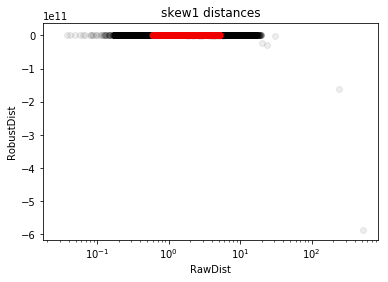

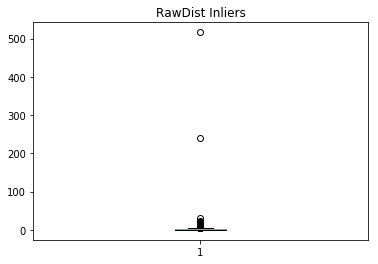

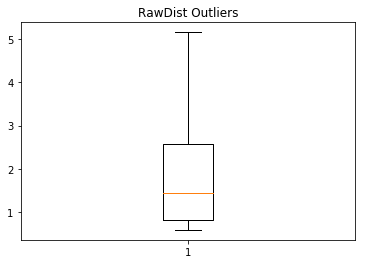

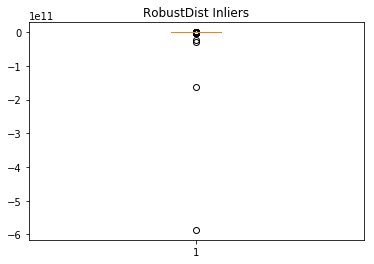

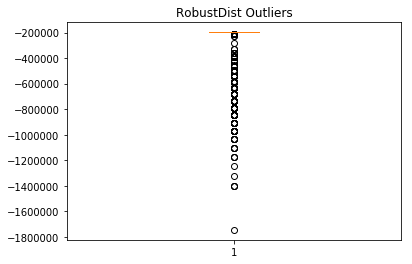

In [10]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("skew1 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [11]:
# Prediction using skew2
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_skew2 = test_df - skew(test_df, axis=0, bias=False)
mahal_dist = pairwise_distances(test_df_skew2, ell_model.raw_skew2_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_skew2),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.23)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the skew2_dist_
pred_test_label = np.full(test_df_skew2.shape[0], 0, dtype=int)
pred_test_label[mahal_dist <= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[skew2][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 18401, 1: 5497}
###[skew2][ drop_features04 ] Test. F1: 0.8521612027563165 , Recall: 1.0 , Precision: 0.7424049481535383


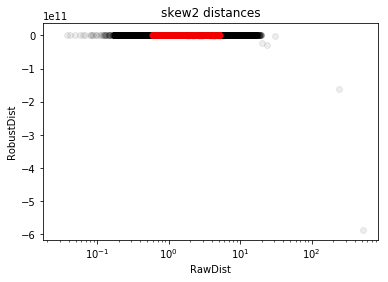

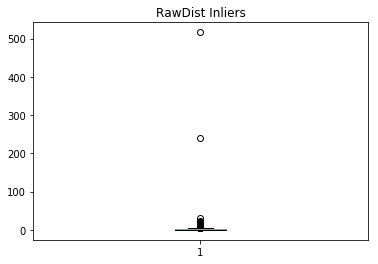

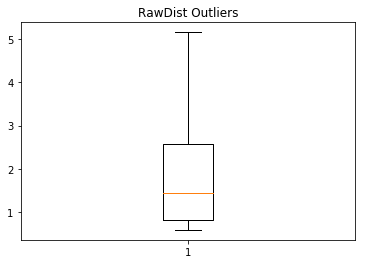

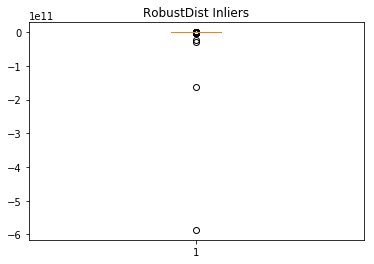

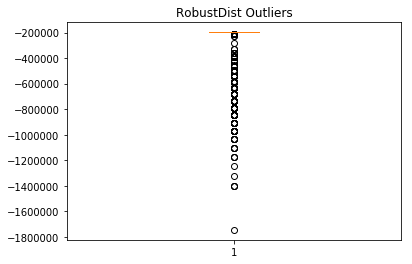

In [12]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("skew2 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [13]:
# Prediction using kurt1
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_kurt1 = test_df - kurtosis(test_df, axis=0, fisher=True, bias=True)
mahal_dist = pairwise_distances(test_df_kurt1, ell_model.raw_kurt1_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_kurt1),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.18)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the kurt1_dist_
pred_test_label = np.full(test_df_kurt1.shape[0], 0, dtype=int)
pred_test_label[mahal_dist <= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[kurt1][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 19594, 1: 4304}
###[kurt1][ drop_features04 ] Test. F1: 0.9734048896839596 , Recall: 1.0 , Precision: 0.9481877323420075


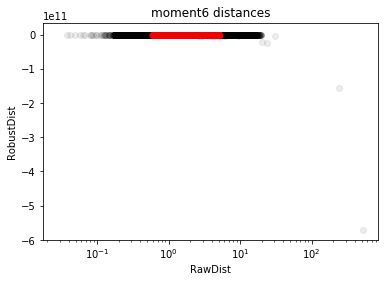

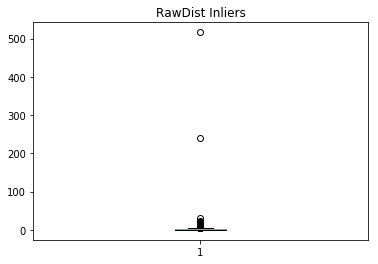

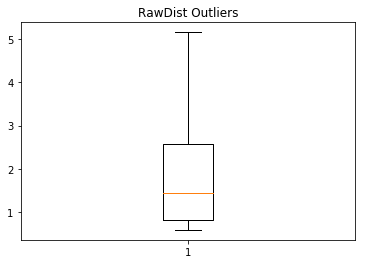

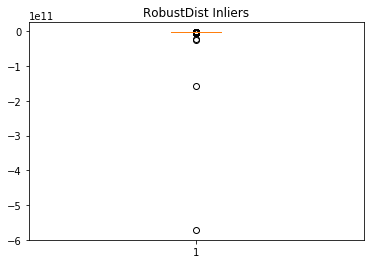

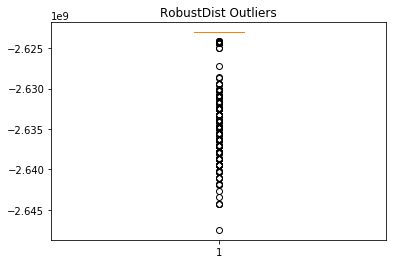

In [14]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment6 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [15]:
# Prediction using kurt2
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_kurt2 = test_df - kurtosis(test_df, axis=0, fisher=False, bias=True)
mahal_dist = pairwise_distances(test_df_kurt2, ell_model.raw_kurt2_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_kurt2),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.18)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the kurt2_dist_
pred_test_label = np.full(test_df_kurt2.shape[0], 0, dtype=int)
pred_test_label[mahal_dist <= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[kurt2][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 19594, 1: 4304}
###[kurt2][ drop_features04 ] Test. F1: 0.9734048896839596 , Recall: 1.0 , Precision: 0.9481877323420075


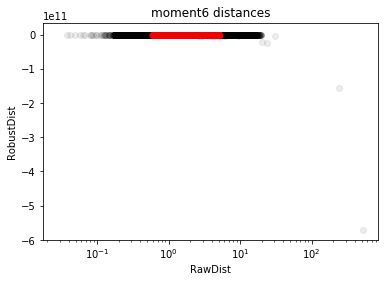

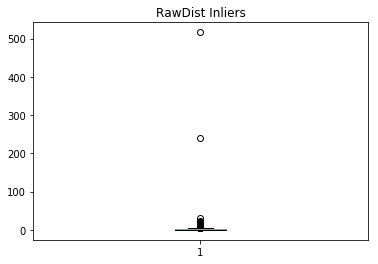

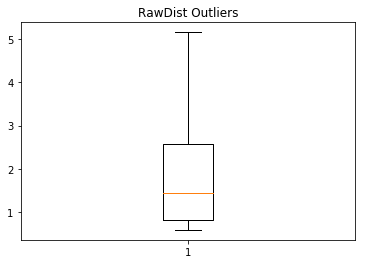

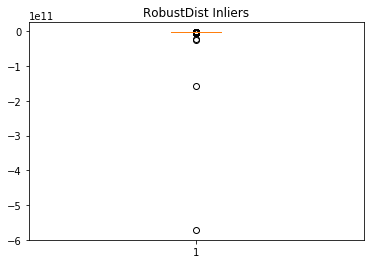

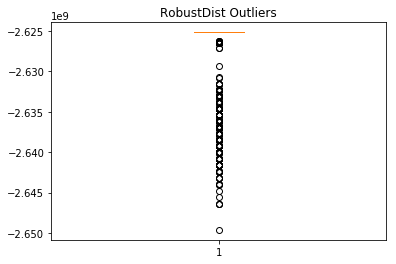

In [16]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment6 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [17]:
# Prediction using moment2
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_moment2 = test_df -moment(test_df, moment=2, axis=0)
mahal_dist = pairwise_distances(test_df_moment2, ell_model.raw_moment2_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_moment2),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.69)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the moment2_dist_
pred_test_label = np.full(test_df_moment2.shape[0], 0, dtype=int)
pred_test_label[mahal_dist >= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[moment2][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 16489, 1: 7409}
###[moment2][ drop_features04 ] Test. F1: 0.5714534377719757 , Recall: 0.8044596912521441 , Precision: 0.44310973140774734


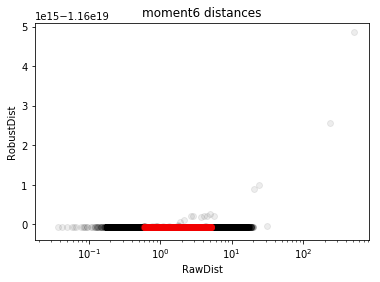

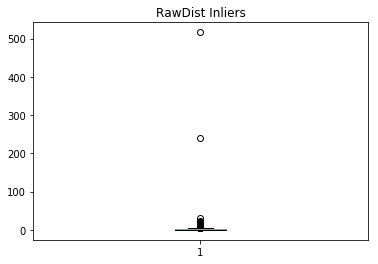

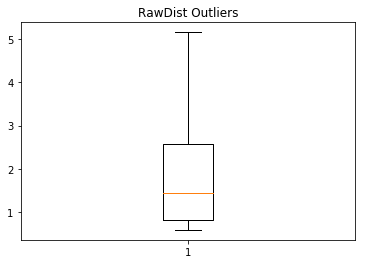

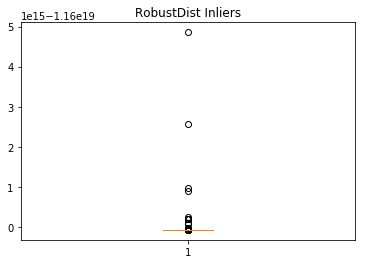

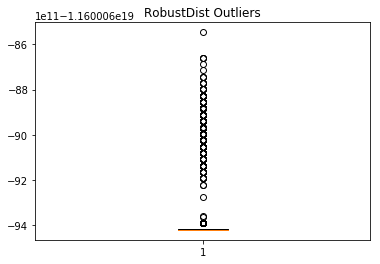

In [18]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment6 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [19]:
# Prediction using moment3
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_moment3 = test_df -moment(test_df, moment=3, axis=0)
mahal_dist = pairwise_distances(test_df_moment3, ell_model.raw_moment3_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_moment3),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.95)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the moment3_dist_
pred_test_label = np.full(test_df_moment3.shape[0], 0, dtype=int)
pred_test_label[mahal_dist <= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[moment3][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {0: 1186, 1: 22712}
###[moment3][ drop_features04 ] Test. F1: 0.3025417086552458 , Recall: 0.9931389365351629 , Precision: 0.1784519196900317


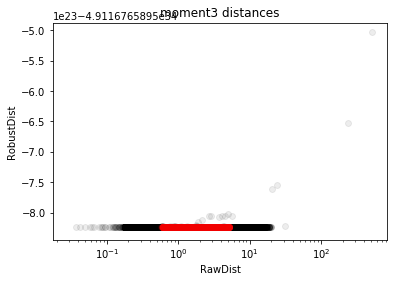

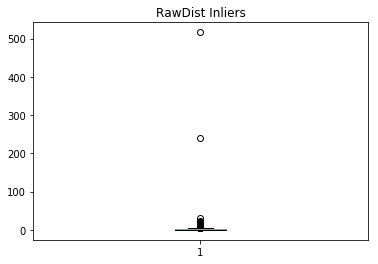

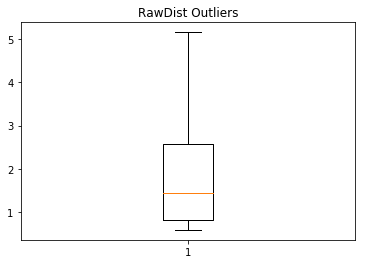

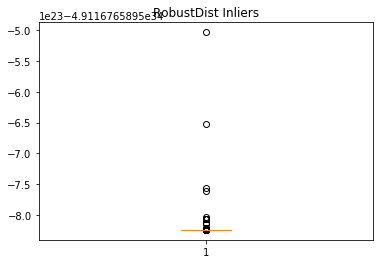

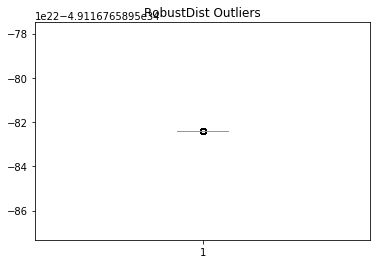

In [20]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment3 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [21]:
# Prediction using moment4
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_moment4 = test_df -moment(test_df, moment=4, axis=0)
mahal_dist = pairwise_distances(test_df_moment4, ell_model.raw_moment4_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_moment4),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.99)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the moment4_dist_
pred_test_label = np.full(test_df_moment4.shape[0], 0, dtype=int)
pred_test_label[mahal_dist >= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[moment4][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {1: 23898}
###[moment4][ drop_features04 ] Test. F1: 0.29171878909181886 , Recall: 1.0 , Precision: 0.1707674282366725


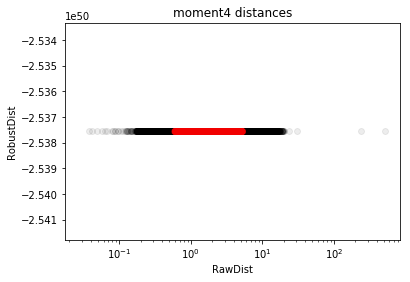

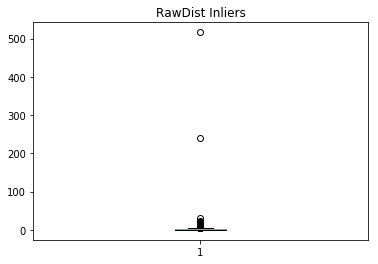

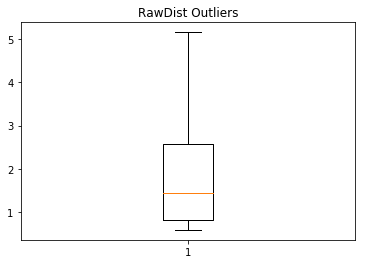

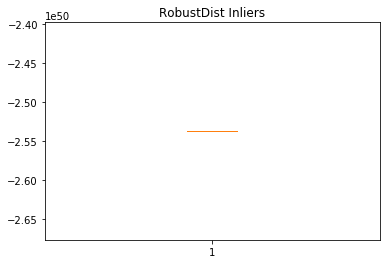

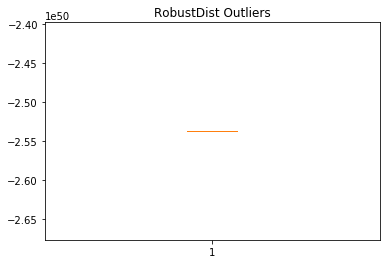

In [22]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment4 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [23]:
# Prediction using moment5
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_moment5 = test_df -moment(test_df, moment=5, axis=0)
mahal_dist = pairwise_distances(test_df_moment5, ell_model.raw_moment5_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_moment5),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.99)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the moment5_dist_
pred_test_label = np.full(test_df_moment5.shape[0], 0, dtype=int)
pred_test_label[mahal_dist >= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[moment5][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {1: 23898}
###[moment5][ drop_features04 ] Test. F1: 0.29171878909181886 , Recall: 1.0 , Precision: 0.1707674282366725


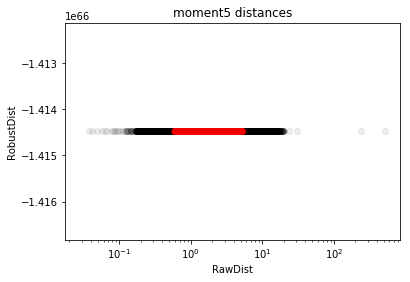

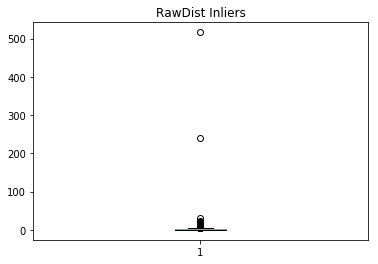

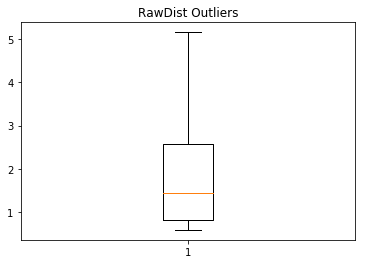

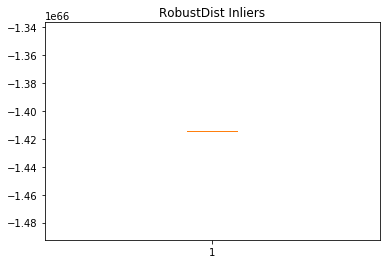

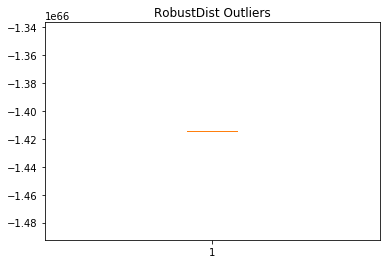

In [24]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment5 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()
fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()

In [25]:
# Prediction using moment6
from scipy.stats import chi2,skew,kurtosis,moment
inv_cov = linalg.pinvh(ell_model.covariance_)
test_df_moment6 = test_df -moment(test_df, moment=6, axis=0)
mahal_dist = pairwise_distances(test_df_moment6, ell_model.raw_moment6_[np.newaxis, :], metric='mahalanobis', VI=inv_cov)
mahal_dist = np.reshape(mahal_dist, (len(test_df_moment6),)) ** 2
mahal_dist = -mahal_dist
contamination_threshold = np.percentile(mahal_dist, 100. * 0.99)# manual contamination testing. here we modify the dec_fuction to use the current mahal_dist intead of the moment6_dist_
pred_test_label = np.full(test_df_moment6.shape[0], 0, dtype=int)
pred_test_label[mahal_dist >= contamination_threshold] = 1

# print results
unique, counts = np.unique(test_label, return_counts=True)
print('Test Labels', dict(zip(unique, counts)))
unique, counts = np.unique(pred_test_label, return_counts=True)
print('Predicted Labels', dict(zip(unique, counts)))
f1, Recall, Precision = get_classification_report(test_label, pred_test_label)
print('###[moment6][', features_key, '] Test. F1:', f1, ', Recall:', Recall, ', Precision:', Precision)

Test Labels {0: 19817, 1: 4081}
Predicted Labels {1: 23898}
###[moment6][ drop_features04 ] Test. F1: 0.29171878909181886 , Recall: 1.0 , Precision: 0.1707674282366725


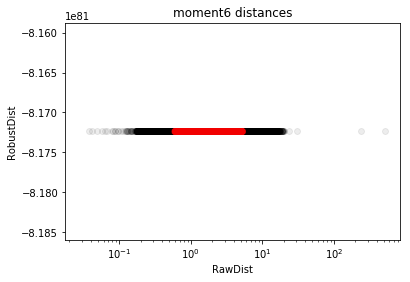

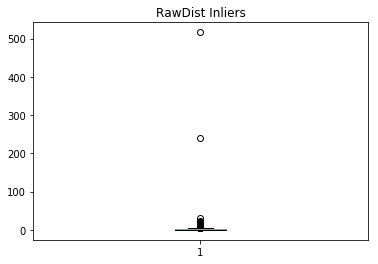

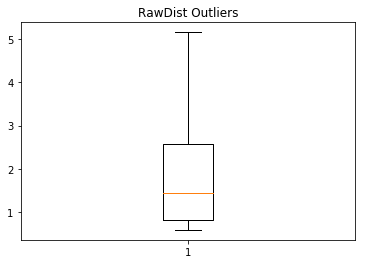

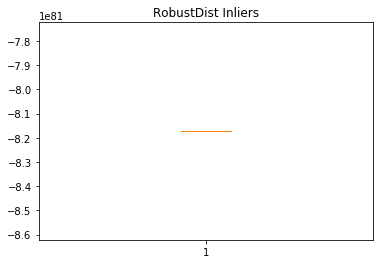

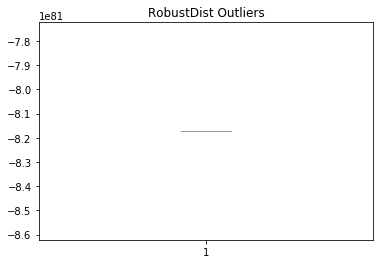

In [26]:
raw_dist = EmpiricalCovariance().fit(norm_train_df).mahalanobis(test_df)
X = pd.DataFrame()
X['RawDist'] = raw_dist
X['RobustDist'] = mahal_dist
X['Label'] = test_label
inlier = X[X["Label"] == 0]
outlier = X[X["Label"] == 1]

# Plot scatter of inliers and outliers
fig = plt.figure()
ax = plt.gca()
ax.scatter(inlier['RawDist'], inlier['RobustDist'], color='black', label='inliers', alpha=0.07)
ax.scatter(outlier['RawDist'], outlier['RobustDist'], color='red', label='outliers', alpha=0.07)
# ax.set_yscale('log')
ax.set_xscale('log')
plt.title("moment6 distances")
plt.xlabel("RawDist")
plt.ylabel("RobustDist")
plt.show()

# Plot the scores for each point
fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Inliers')
ax1.boxplot(inlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RawDist Outliers')
ax1.boxplot(outlier['RawDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Inliers')
ax1.boxplot(inlier['RobustDist'])
plt.show()

fig1, ax1 = plt.subplots()
ax1.set_title('RobustDist Outliers')
ax1.boxplot(outlier['RobustDist'])
plt.show()